In [1]:
import pandas as pd
import numpy as np
import obonet
import networkx as nx

# Load the data generated from the R code

In [2]:
bp_db = pd.read_csv("../data/annotations-gene-GO.csv")
bp_db = bp_db.drop_duplicates()
bp_db.head()

,ENSEMBL,GO
0,ENSG00000000003,GO:0039532
1,ENSG00000000003,GO:0043123
2,ENSG00000000003,GO:1901223
3,ENSG00000000005,GO:0001886
4,ENSG00000000005,GO:0001937


In [3]:
bp_db.describe()

,ENSEMBL,GO
count,132627,132627
unique,17599,12305
top,ENSG00000148400,GO:0006357
freq,158,1426


In [4]:
counts1 = pd.read_csv("../data/counts1.csv", index_col=0)
counts1.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSGR0000167393,ENSGR0000169084,ENSGR0000169093,ENSGR0000178605,ENSGR0000182378,ENSGR0000185291,ENSGR0000198223,ENSGR0000214717,ENSGR0000223511,ENSGR0000223773
089357B,14,7,103,241,72,2057,30,60,207,367,...,1,0,0,0,0,0,0,0,0,0
089366A,11,2,194,511,110,3325,36,111,186,530,...,0,0,0,0,0,0,1,0,0,1
089412B,8,0,312,450,106,3751,45,160,325,653,...,0,0,0,0,0,0,1,0,0,0
089425B,9,0,135,496,133,2758,26,93,182,620,...,0,0,0,0,0,0,0,0,0,0
089687A,4,0,89,267,49,2181,24,75,122,263,...,0,0,0,0,0,0,1,0,0,0


In [5]:
pheno1 = pd.read_csv("../data/pheno1.csv", index_col=0)
pheno1.head()

,age,diagnosis,sex,lithium,condition
089357B,18,Control,F,0,Control
089366A,19,Control,F,0,Control
089412B,23,Control,F,0,Control
089425B,47,Control,F,0,Control
089687A,52,Control,F,0,Control


# Data Exploration Analysis

In [6]:
available_genes = set(bp_db.ENSEMBL)
("length of all_genes :", len(available_genes))

('length of all_genes :', 17600)

In [7]:
data_genes = set(counts1.columns)
("length of data_genes :", len(data_genes))

('length of data_genes :', 52645)

In [8]:
("Number of genes missing :", len(data_genes - available_genes))

('Number of genes missing :', 35046)

In [9]:
("Ratio of genes missing : {:.2f}%".format(len(data_genes - available_genes) / len(data_genes) * 100))

'Ratio of genes missing : 66.57%'

# Clean the GO annotations and the GO graph

## only keep GO annotations that are associated with the genes in the data

In [10]:
bp_db = bp_db[bp_db.ENSEMBL.isin(counts1.columns)]
bp_db.describe()

,ENSEMBL,GO
count,132627,132627
unique,17599,12305
top,ENSG00000148400,GO:0006357
freq,158,1426


In [11]:
bp_db_go = set(bp_db.GO)
bp_db_genes = set(bp_db.ENSEMBL)

## load GO graph

In [12]:
# Read the gene ontology
!wget http://purl.obolibrary.org/obo/go/go-basic.obo 
original_graph = obonet.read_obo('go-basic.obo')
!rm go-basic.obo

--2024-04-24 00:19:43--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 2606:4700:4400::6812:253b, 2606:4700:4400::ac40:96c5, 172.64.150.197, ...
Connecting to purl.obolibrary.org (purl.obolibrary.org)|2606:4700:4400::6812:253b|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2024-04-24 00:19:44--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 2600:9000:24db:3e00:d:ff6c:c780:93a1, 2600:9000:24db:600:d:ff6c:c780:93a1, 2600:9000:24db:5e00:d:ff6c:c780:93a1, ...
Connecting to current.geneontology.org (current.geneontology.org)|2600:9000:24db:3e00:d:ff6c:c780:93a1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31245945 (30M) [text/obo]
Saving to: ‘go-basic.obo’

go-basic.obo        100%[===================>]  29.80M  10.1MB/s    in 2.9s    

20

## only keep the Biological Process (BP) subgraph

In [13]:
bp_node = "GO:0008150"
bp_graph_nodes = nx.ancestors(original_graph, bp_node)
bp_graph_nodes.add(bp_node)
bp_graph = original_graph.subgraph(bp_graph_nodes)
print("Number of nodes in the graph", len(bp_graph))

Number of nodes in the graph 27046


## filter the GO terms that are not in the graph

In [14]:
bp_db = bp_db[bp_db.GO.isin(bp_graph_nodes)]
bp_db.describe()

,ENSEMBL,GO
count,131767,131767
unique,17589,12101
top,ENSG00000148400,GO:0006357
freq,158,1426


##  remove the branch whose all descendants nodes are not in the list of GO terms

In [15]:
from tqdm import tqdm

leaves = [x for x in bp_graph_nodes if bp_graph.in_degree(x) == 0 and x not in bp_db_go]
removes, keeps = set(), set()

for child in tqdm(leaves):
    ancestors = nx.descendants(bp_graph, child)
    for ancestor in ancestors:
        if ancestor not in removes and ancestor not in keeps:
            if ancestor not in bp_db_go:
                descendants = set(nx.ancestors(bp_graph, ancestor))
                if len(descendants.intersection(bp_db_go)) == 0:
                    removes.add(ancestor)
                else:
                    keeps.add(ancestor)
            else:
                keeps.add(ancestor)
removes = removes.union(set(leaves))
len(removes)

100%|██████████| 7256/7256 [01:53<00:00, 64.06it/s] 


11707

draw the subgraph to show the nodes that will be removed

['GO:1900870', 'GO:1900869', 'GO:0006793', 'GO:0044237', 'GO:0008152', 'GO:0008150']
Number of nodes in the sub graph 6
Number of removed nodes 2 {'GO:1900869', 'GO:1900870'}


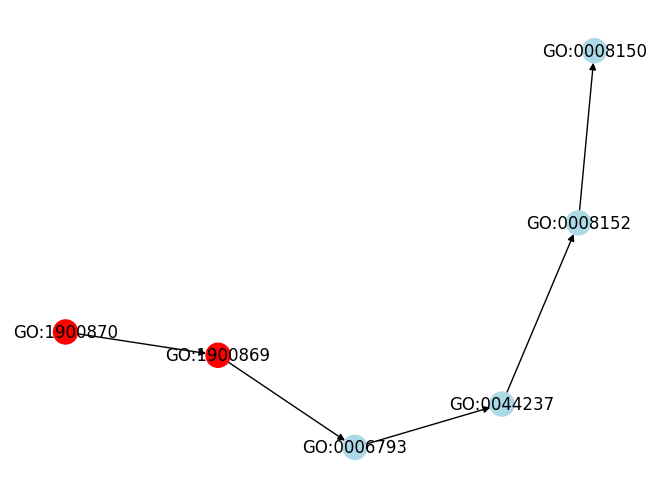

In [16]:
remove_nodes = set()
tmp_nodes = []

for node in removes:
    tmp_nodes = nx.shortest_path(bp_graph, node, bp_node)
    remove_nodes = set([x for x in tmp_nodes if x in removes])
    if len(remove_nodes) > 1:
        break

print(tmp_nodes)
tmp_subgraph = bp_graph.subgraph(tmp_nodes)

colors = ['red' if node in removes else 'lightblue' for node in tmp_subgraph.nodes()]
#print(colors)

print("Number of nodes in the sub graph", len(tmp_subgraph))
print("Number of removed nodes", len(remove_nodes), remove_nodes)

nx.draw(tmp_subgraph, with_labels=True, node_color=colors)

In [17]:
bp_graph = bp_graph.subgraph(bp_graph_nodes - set(removes))
print("Number of nodes in the graph", len(bp_graph))

Number of nodes in the graph 15339


## for a genes, which connected to multiple GO terms in the same branch, only keep the GO term that is the closest to the leave 

In [18]:
go_genes_map = {}
for idx, row in bp_db.iterrows():
    go = row.GO
    gene = row.ENSEMBL
    if go not in go_genes_map:
        go_genes_map[go] = set()
    go_genes_map[go].add(gene)

leaves = [x for x in bp_graph_nodes if bp_graph.in_degree(x) == 0]

removes_terms = set()


def dfs(node):
    res = set()
    if bp_graph.in_degree(node) != 0:  # collect all the genes from the parents
        for parent in bp_graph.predecessors(node):
            res = res.union(dfs(parent))
    if node in go_genes_map:  # compare and record the genes that already appears in the parents
        for gene in go_genes_map[node].intersection(res):
            removes_terms.add(tuple([node, gene]))
        res = res.union(go_genes_map[node])
    return res


_ = dfs(bp_node)
len(removes_terms)

23719

draw the subgraph to show the annotations that will be removed

Number of nodes in the sub graph 9
Number of nodes with the same genes 4 ['GO:0006868', 'GO:2000487', 'GO:0010585', 'GO:1903803']


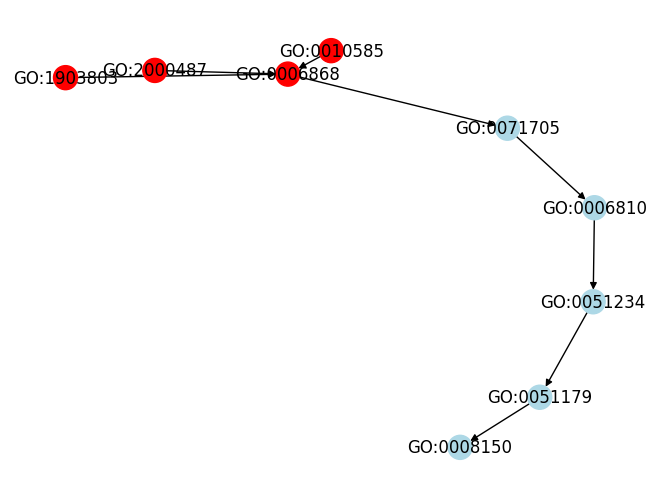

In [19]:
_go, _gene = list(removes_terms)[0]
_all_go = set(bp_db[bp_db.ENSEMBL == _gene]["GO"].values)
tmp_nodes = nx.shortest_path(bp_graph, _go, bp_node)
for x in set(bp_graph.predecessors(_go)):
    if x in _all_go:
        tmp_nodes.append(x)

same_genes_node = [x for x in tmp_nodes if x in _all_go]
tmp_subgraph = bp_graph.subgraph(tmp_nodes)
colors = ['red' if node in _all_go else 'lightblue' for node in tmp_subgraph.nodes()]
print("Number of nodes in the sub graph", len(tmp_subgraph))
print("Number of nodes with the same genes", len(same_genes_node), same_genes_node)

nx.draw(tmp_subgraph, with_labels=True, node_color=colors)

In [20]:
bp_db = bp_db[~bp_db.apply(lambda x: tuple([x.GO, x.ENSEMBL]) in removes_terms, axis=1)]
bp_db.describe()

,ENSEMBL,GO
count,108048,108048
unique,17589,11767
top,ENSG00000148400,GO:0045944
freq,126,1105


## define a function that can remove the lowest level of the GO terms, and re-assign the genes to the parent GO term

In [21]:
def remove_lowest_level(graph, bp_df):
    _leaves = [x for x in graph.nodes if graph.in_degree(x) == 0]
    new_tuples = set()
    for _idx, _row in bp_df[bp_df.GO.isin(_leaves)].iterrows():
        _gene = _row.ENSEMBL
        _go = _row.GO
        for _parent in graph.successors(_go):
            new_tuples.add((_gene, _parent))
    new_df = pd.concat([bp_df[~bp_df.GO.isin(_leaves)], pd.DataFrame(new_tuples, columns=["ENSEMBL", "GO"])],
                       ignore_index=True)
    new_graph = graph.subgraph(set(graph.nodes) - set(_leaves))
    return new_graph, new_df


sub_graph, sub_bp_db = remove_lowest_level(bp_graph, bp_db)

In [22]:
print("After removing the lowest level, the number of nodes in the graph", len(sub_graph))
sub_bp_db = sub_bp_db.drop_duplicates()
sub_bp_db.describe()

After removing the lowest level, the number of nodes in the graph 9917


,ENSEMBL,GO
count,147459,147459
unique,17589,8775
top,ENSG00000148400,GO:0045944
freq,206,1165


draw the subgraph to show the nodes that will be removed

['GO:0051391', 'GO:0006400', 'GO:0009451', 'GO:0043412', 'GO:0043170', 'GO:0071704', 'GO:0008152', 'GO:0008150']
Number of nodes in the sub graph 13
Number of removed nodes 1 ['GO:0051391']
Genes before re-assign:
                ENSEMBL          GO
4987    ENSG00000031698  GO:0006400
9388    ENSG00000066654  GO:0006400
19066   ENSG00000090861  GO:0006400
28014   ENSG00000104047  GO:0006400
40709   ENSG00000113272  GO:0006400
65126   ENSG00000134461  GO:0006400
66557   ENSG00000135372  GO:0051391
72146   ENSG00000138385  GO:0006400
103666  ENSG00000165832  GO:0006400
110361  ENSG00000169570  GO:0006400
Genes after re-assign:
                ENSEMBL          GO
2682    ENSG00000031698  GO:0006400
5023    ENSG00000066654  GO:0006400
10172   ENSG00000090861  GO:0006400
14924   ENSG00000104047  GO:0006400
21682   ENSG00000113272  GO:0006400
34556   ENSG00000134461  GO:0006400
38262   ENSG00000138385  GO:0006400
55351   ENSG00000165832  GO:0006400
58951   ENSG00000169570  GO:0006400
82829  

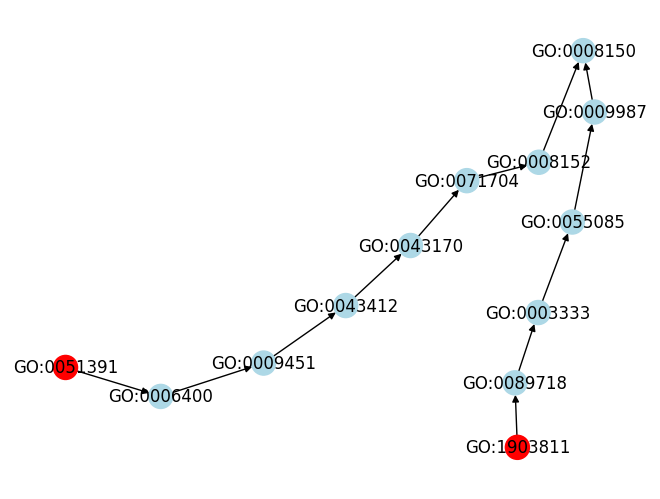

In [23]:
removed_nodes = list(set(bp_graph.nodes) - set(sub_graph.nodes))
tmp_nodes = nx.shortest_path(bp_graph, removed_nodes[0], bp_node)
tmp_nodes2 = nx.shortest_path(bp_graph, removed_nodes[1], bp_node)
print(tmp_nodes)

tmp_subgraph = bp_graph.subgraph(tmp_nodes+tmp_nodes2)

colors = ['red' if node in removed_nodes else 'lightblue' for node in tmp_subgraph.nodes()]
#print(colors)

print("Number of nodes in the sub graph", len(tmp_subgraph))
print("Number of removed nodes", len(removed_nodes[:1]), removed_nodes[:1])
print("Genes before re-assign:")
print(bp_db[bp_db.GO.isin(tmp_nodes[:2])])
print("Genes after re-assign:")
print(sub_bp_db[sub_bp_db.GO.isin(tmp_nodes[:2])])

nx.draw(tmp_subgraph, with_labels=True, node_color=colors)

In [24]:
def remove_lowest_level(graph, bp_df):
    _leaves = [x for x in graph.nodes if graph.in_degree(x) == 0]
    new_tuples = set()
    for _idx, _row in bp_df[bp_df.GO.isin(_leaves)].iterrows():
        _gene = _row.ENSEMBL
        _go = _row.GO
        for _parent in graph.successors(_go):
            new_tuples.add((_gene, _parent))
    new_df = pd.concat([bp_df[~bp_df.GO.isin(_leaves)], pd.DataFrame(new_tuples, columns=["ENSEMBL", "GO"])],
                       ignore_index=True)
    new_graph = graph.subgraph(set(graph.nodes) - set(_leaves))
    return new_graph, new_df


sub_graph_2, sub_bp_db_2 = remove_lowest_level(sub_graph, sub_bp_db)

In [25]:
print("After removing the lowest two levels, the number of nodes in the graph", len(sub_graph_2))
sub_bp_db_2 = sub_bp_db_2.drop_duplicates()
sub_bp_db_2.describe()

After removing the lowest two levels, the number of nodes in the graph 6273


,ENSEMBL,GO
count,181226,181226
unique,17589,5860
top,ENSG00000148400,GO:0045944
freq,248,1206


## write the GO annotations and the GO graph to a file

In [26]:
def write_gml(graph, filename):
    tmp_graph = nx.Graph()
    tmp_graph.add_nodes_from(graph.nodes())
    tmp_graph.add_edges_from(graph.edges())
    nx.write_gml(tmp_graph, "../data/" + filename + ".gml")


bp_db.reset_index(drop=True, inplace=True)
sub_bp_db.to_csv("../data/bp_db.csv")
write_gml(sub_graph, "bp_graph")